# Autoencoder-based phenotype derivation
- Start out using a vanilla autoencoder with latent dimension 64 (ResNet architecture trained on CIFAR-10).
- Perform GWAS on the resulting latent space

In [1]:
# Import things for vanilla autoencoder
# Taken from https://colab.research.google.com/github/clementchadebec/benchmark_VAE/blob/main/examples/notebooks/models_training/ae_training.ipynb#scrollTo=Hj3IVCWzObYS
import torch
import torchvision.datasets as datasets
import torch.nn as nn

from pythae.models import AE, AEConfig
from pythae.trainers import BaseTrainerConfig
from pythae.pipelines.training import TrainingPipeline
from pythae.models.nn.benchmarks.cifar import Encoder_ResNet_AE_CIFAR, Decoder_ResNet_AE_CIFAR

# Import everything else needed for image processing
import os
from datetime import datetime
from natsort import natsorted
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
from torchvision.transforms import v2 as transforms
from torchvision.io import read_image
from PIL import Image as PILImage
from pathlib import Path
from torchvision.utils import save_image
import torchvision.transforms.functional as TF
from torchvision import models
import scanpy as sc
from matplotlib.pyplot import rc_context
from pathlib import Path
import pandas as pd
import matplotlib.image as mpimg
from colorir import *
import tensorflow as tf

/hps/software/users/birney/esther/micromamba/envs/indigene-img/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/hps/software/users/birney/esther/micromamba/envs/indigene-img/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
2024-06-11 13:40:52.761801: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-11 13:40:52.807897: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary i

In [2]:
palette = Palette.load('cam_colours')
torch.manual_seed(1)

#### Make the output directory for images generated today

In [3]:
# Output path of generated images
today = datetime.now().strftime('%Y-%m-%d')

# Define the directory path
workdir = f"/nfs/research/birney/users/esther/medaka-img/scripts/figures/{today}/"

# Create the directory
os.makedirs(workdir, exist_ok=True)

print(workdir)

/nfs/research/birney/users/esther/medaka-img/scripts/figures/2024-05-13/


In [3]:
# Directory of flipped, transformed images (output of flip-img.ipynb)
transformed_files_dir = '../flipped_transformed_images2/'
unflipped_files_dir = '../transformed_images/'

In [4]:
# Custom min-max scaling function to pass into Compose; transforms pixel values to range [0,1] for each image individually
class MinMaxScaling:
    def __call__(self, tensor):
        return (tensor - tensor.min()) / (tensor.max() - tensor.min())

In [5]:
transform = transforms.Compose([
        transforms.Resize(size = (32,32)),
        transforms.ToImage(), # Convert to PIL image
        transforms.ToDtype(torch.float32, scale=True), # Convert to float32; use instead of deprecated ToTensor()
        MinMaxScaling()
])

In [6]:
test_name = "PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_A01"

(256, 256, 3)
uint8
0 255


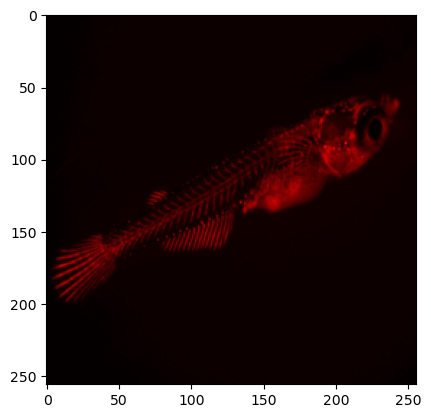

In [7]:
test_image = ski.io.imread(transformed_files_dir + 'image/' + test_name + '.tif')

print(test_image.shape)
print(test_image.dtype)
print(test_image.min(), test_image.max())

test_image_plot = plt.imshow(test_image)
plt.show()

torch.Size([3, 32, 32])
torch.float32
tensor(0.) tensor(1.)


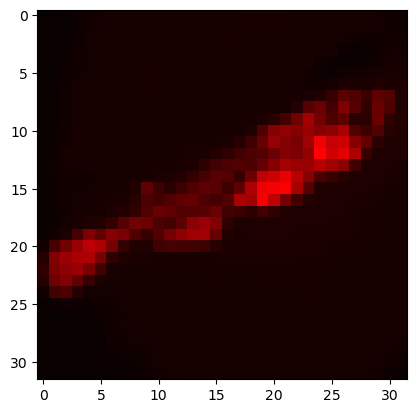

In [8]:
test_image_resized = transform(PILImage.fromarray(test_image))

print(test_image_resized.shape)
print(test_image_resized.dtype)
print(test_image_resized.min(), test_image_resized.max())

test_image_resized_plot = plt.imshow(test_image_resized.permute(1, 2, 0))
plt.show()

(32, 32, 3)
uint8
12 219


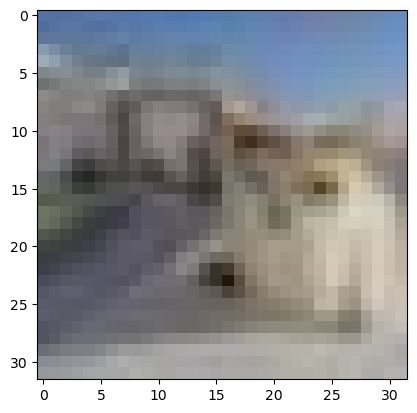

In [9]:
test_image_resized = ski.io.imread('../cifar-example.jpg')

print(test_image_resized.shape)
print(test_image_resized.dtype)
print(test_image_resized.min(), test_image_resized.max())

test_image_resized_plot = plt.imshow(test_image_resized)
plt.show()

In [10]:
model_config = AEConfig(
    input_dim=(3, 32, 32),
    latent_dim=64
)

model = AE(
    model_config=model_config,
    encoder=Encoder_ResNet_AE_CIFAR(model_config), 
    decoder=Decoder_ResNet_AE_CIFAR(model_config) 
)

In [12]:
# print(TF.to_tensor(test_image_resized).shape)
test_image_resized_encoded = model.encoder(test_image_resized.unsqueeze(0))
# test_image_resized_encoded = model.encoder(TF.to_tensor(test_image_resized).unsqueeze(0))
# print(test_image_resized_encoded['embedding'].shape)

test_image_resized_decoded = model.decoder(test_image_resized_encoded['embedding'])
# print(test_image_resized_decoded)
print(test_image_resized_decoded['reconstruction'].detach().shape)
plt.imshow(test_image_resized_decoded['reconstruction'][0].detach().permute(1, 2, 0))

AttributeError: 'numpy.ndarray' object has no attribute 'unsqueeze'

In [11]:
test_tensor = torch.load(transformed_files_dir + 'tensor/' + test_name + '.pt')

print(test_tensor.shape)

torch.Size([3, 256, 256])


In [ ]:
# x = torch.randn(1, 1, 224, 224)
# model = models.vgg16(pretrained=False) # pretrained=False just for debug reasons
# first_conv_layer = [nn.Conv2d(1, 3, kernel_size=3, stride=1, padding=1, dilation=1, groups=1, bias=True)]
# first_conv_layer.extend(list(model.features))  
# model.features= nn.Sequential(*first_conv_layer )  
# output = model(x)

In [14]:
# print(test_tensor.unsqueeze(0).shape)

# feature = model.encoder(torch.rand(1, 3, 32, 32))
feature = model.encoder(test_image_resized.unsqueeze(0))
print(type(feature[0]))

AttributeError: 'numpy.ndarray' object has no attribute 'unsqueeze'

In [ ]:
# feature_matrix = []
# counter = 0

# for img_name in natsorted(os.listdir(path = transformed_files_dir + 'image/')):
#     counter += 1
#     img = ski.io.imread(transformed_files_dir + 'image/' + img_name)
#     feature = model.encoder(transform(PILImage.fromarray(img)).unsqueeze(0))

#     feature_matrix.append(feature[0].detach())
#     if counter % 10 == 0:
#         print(counter)

In [63]:
# torch.save(feature_matrix, ('../features/pythae_ResNet_AE_CIFAR_resized_input.pt'))

In [8]:
print(feature_matrix.shape)

(2353, 64)


In [4]:
# Load the feature matrix
feature_list = torch.load('../features/pythae_ResNet_AE_CIFAR_unflipped_resized_input.pt')
feature_matrix = np.array(([np.array(i) for [i] in feature_list]))

# Create the AnnData object to calculate UMAP (ScanPy)
obs_names = [file.rsplit(".", 1)[0] for file in natsorted(os.listdir(path = '../flipped_transformed_images/image/'))]

feature_matrix_anndata = sc.AnnData(X = feature_matrix)
feature_matrix_anndata.obs_names = obs_names

# print(obs_names)
print(feature_matrix_anndata)

AnnData object with n_obs × n_vars = 2353 × 64


In [7]:
# set up UMAP
seed = np.random.RandomState(seed=0)
neighbors_anndata = sc.pp.neighbors(feature_matrix_anndata,
                                     use_rep='X',
                                     n_neighbors = 49,
                                     random_state = seed,
                                     copy = True)
umap_anndata = sc.tl.umap(neighbors_anndata,
                          random_state = seed,
                          copy = True)

### Plot left vs right on the new UMAP from a 64-dimensional latent space

Text(0.5, 1.0, "UMAP of 2353 samples with \n manual colour-coding 'left' vs 'right'")

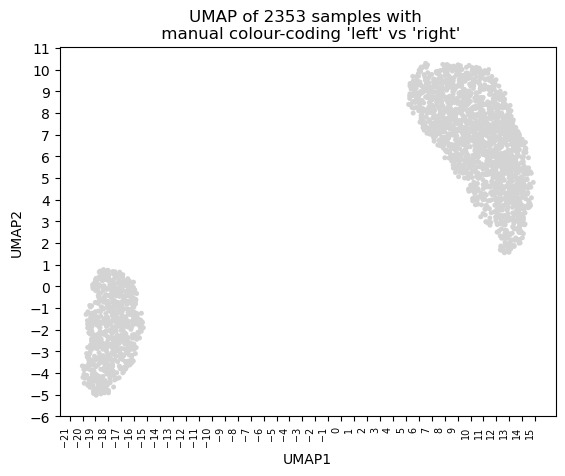

In [8]:
ax = sc.pl.umap(umap_anndata,
               use_raw=False,
               show = False)

ax.set_yticks(list(range(int(np.floor(min(umap_anndata.obsm['X_umap'][:, 1]))), 
                         int(np.ceil(max(umap_anndata.obsm['X_umap'][:, 1]))) + 1, 1)))
ax.set_xticks(list(range(int(np.floor(min(umap_anndata.obsm['X_umap'][:, 0]))), 
                         int(np.ceil(max(umap_anndata.obsm['X_umap'][:, 0]))) + 1, 1)))
plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right', fontsize='x-small')

# ax.axvline(x=5.6, color=palette.dark_green)
# ax.text(5.8, -2, '5.6', color='black', fontsize=12, bbox=dict(facecolor=palette.dark_green, alpha=0.5))
# ax.axvline(x=5.2, color=palette.core_green)
# ax.text(4.09, 0, '5.2', color='black', fontsize=12, bbox=dict(facecolor=palette.core_green, alpha=0.5))
# ax.axvline(x=6, color=palette.core_green)
# ax.text(6.17, -4, '6.0', color='black', fontsize=12, bbox=dict(facecolor=palette.core_green, alpha=0.5))
ax.set_title("UMAP of 2353 samples with \n manual colour-coding 'left' vs 'right'")

#### Plot the random subset of fish images to assess left/right

In [9]:
training_imgs = []
training_tensors = []

training_imgs += [(transformed_files_dir + '/image/' + file) for file in os.listdir(transformed_files_dir + '/image/') if file.endswith('E1.tif')]
training_tensors += [(unflipped_files_dir + '/tensor/' + file) for file in os.listdir(transformed_files_dir + '/tensor/') if file.endswith('E1.pt')]

training_imgs = natsorted(training_imgs)
training_tensors = natsorted(training_tensors)

training_tensor_names = [s.split('/tensor/')[1].split('.pt')[0] for s in training_tensors]

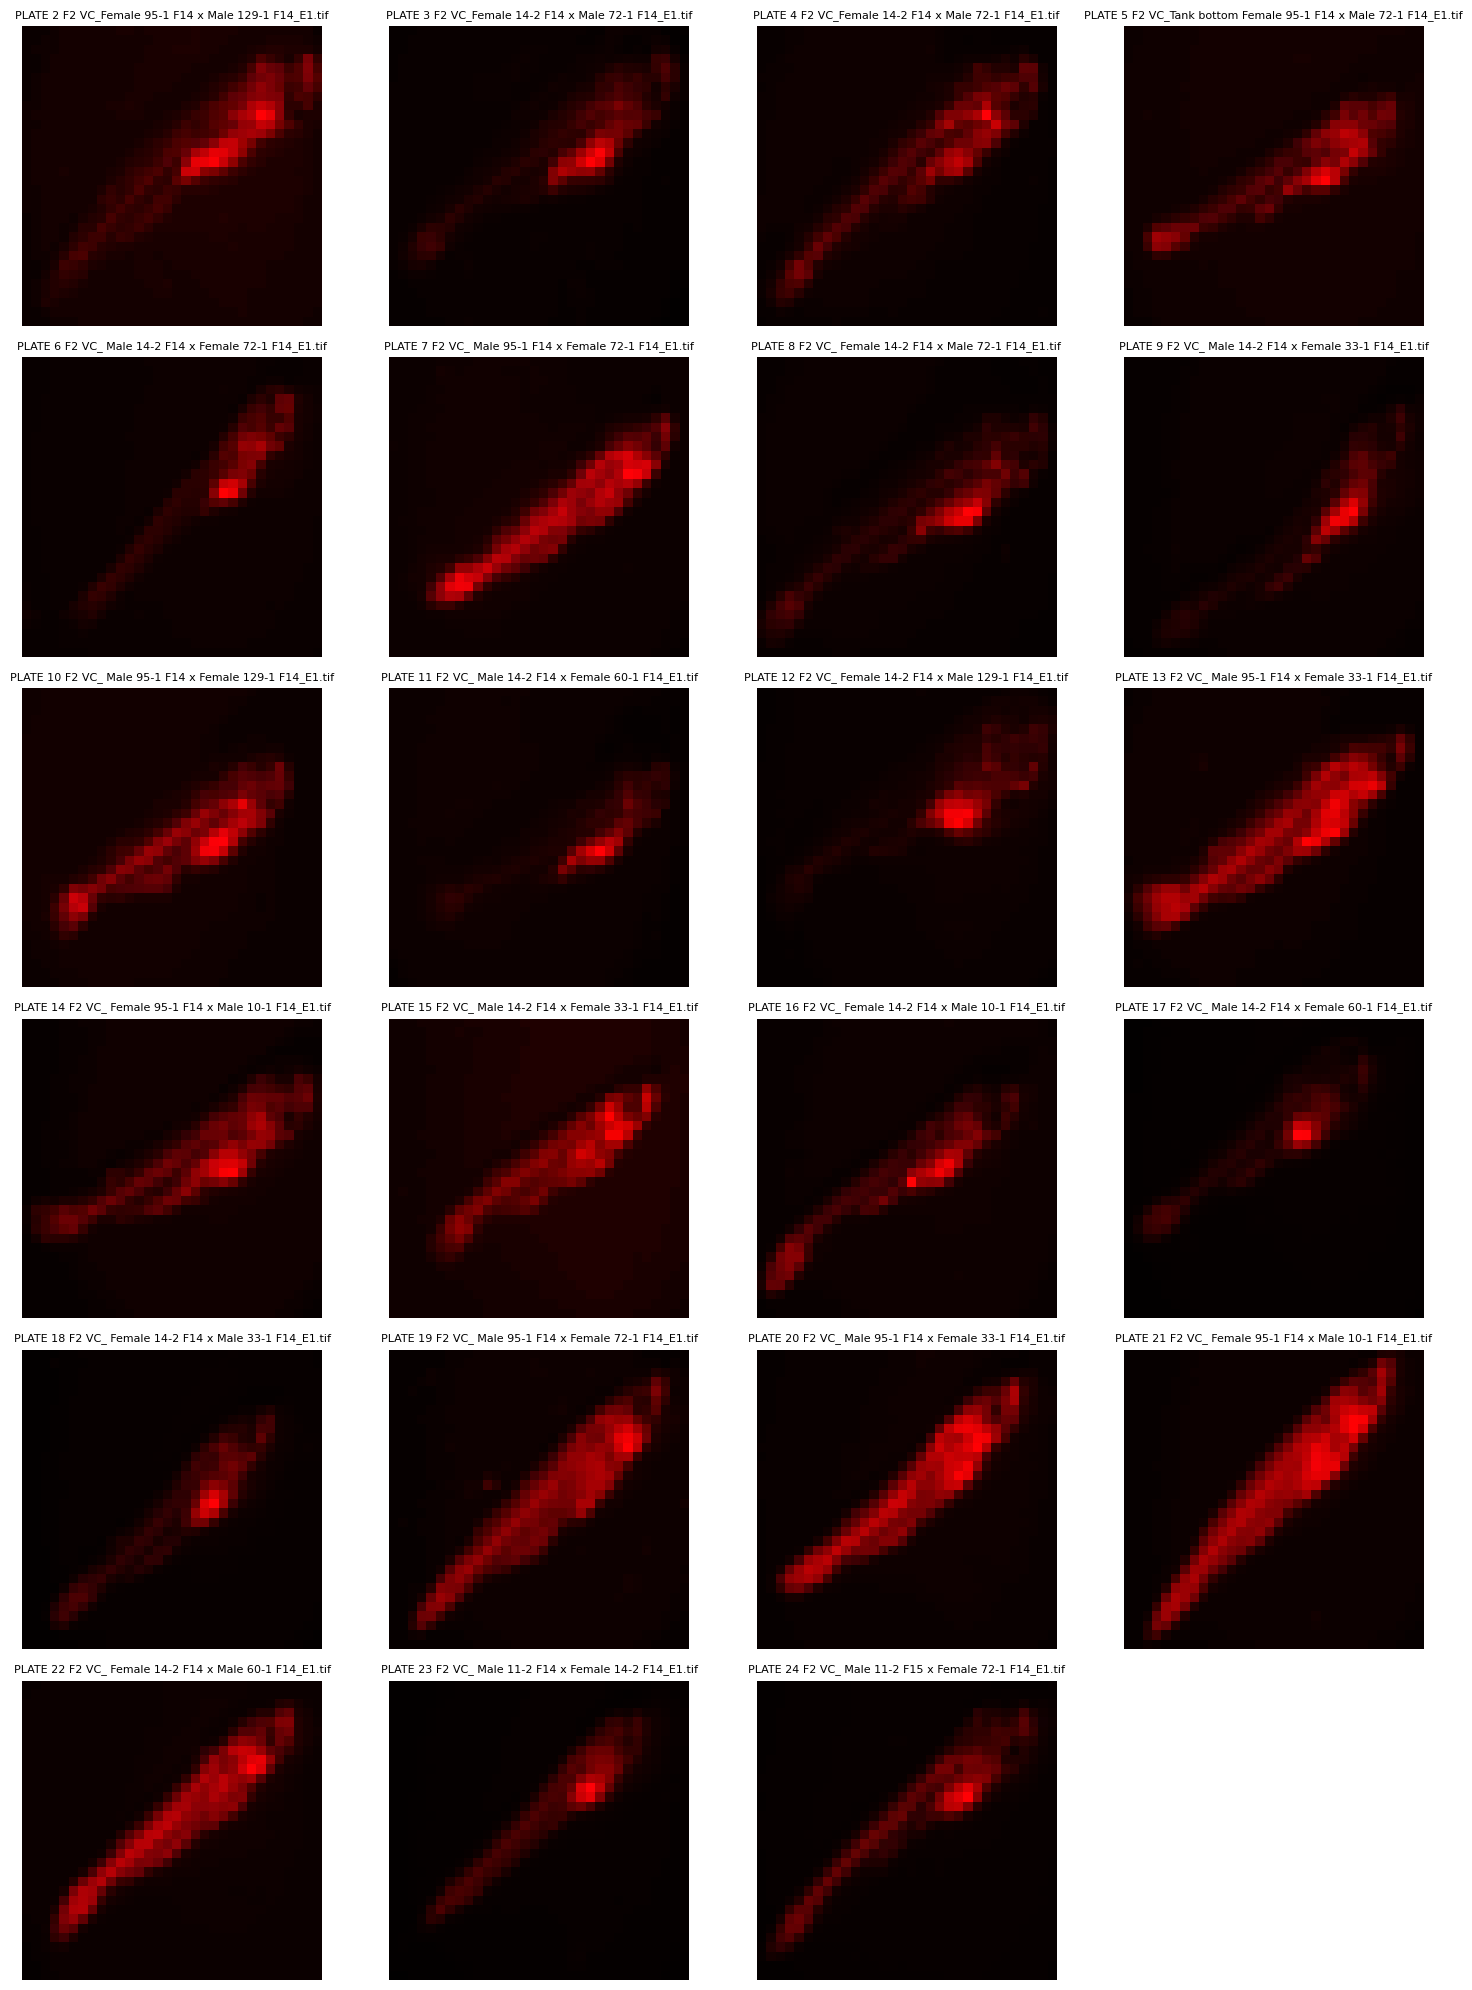

In [10]:
fig, axs = plt.subplots(6, 4, figsize=(15, 20))

# fig.suptitle("Random selection of fish images before flipping", fontsize = 15)
for i, ax in enumerate(axs.flatten()):
    if i < len(training_imgs):
        img = mpimg.imread(training_imgs[i])
        # img_before = mpimg.imread(training_imgs[i])
        # img = transform(img_before).permute(1, 2, 0)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(os.path.basename(training_imgs[i]), fontsize = '8')
fig.delaxes(axs.flatten()[23])
plt.tight_layout()

# plt.savefig(workdir + 'random_unflipped_fish_imgs.png')
# plt.savefig(workdir + 'random_unflipped_fish_imgs.svg')

plt.show()

In [11]:
obs = [Path(file.rsplit(".", 1)[0]).stem for file in training_tensors]
training_left_right = ['right', 'left', 'left', 'right', 
                       'right', 'left', 'left', 'right',
                       'left', 'left', 'right', 'left', 
                       'right', 'right', 'right', 'right', 
                       'right', 'right', 'right', 'right',
                       'right', 'right', 'right']

# obs = np.array([obs, training_left_right]).T
obs = obs + ['left_vs_right']

In [12]:
# Merge left/right designation to anndata.obs_names
left_right = pd.DataFrame(training_tensor_names).merge(pd.DataFrame(training_left_right),
                                                                     left_index = True,
                                                                     right_index = True,
                                                                     how = 'left')

left_right = left_right.rename(columns={'0_x': 'samplename',
                                        '0_y': 'left_vs_right'})
left_right
# umap_anndata.obs['left_vs_right'].unique()

direction_df = pd.DataFrame(umap_anndata.obs).merge(left_right, 
                                                     left_index = True,
                                                     right_on = 'samplename',
                                                     how = 'left')

# direction_df
# direction_df['left_vs_right'].unique()
umap_anndata.obs["left_vs_right"] = pd.Categorical(direction_df['left_vs_right'])

umap_anndata.obs['left_vs_right'].unique()

[NaN, 'right', 'left']
Categories (2, object): ['left', 'right']

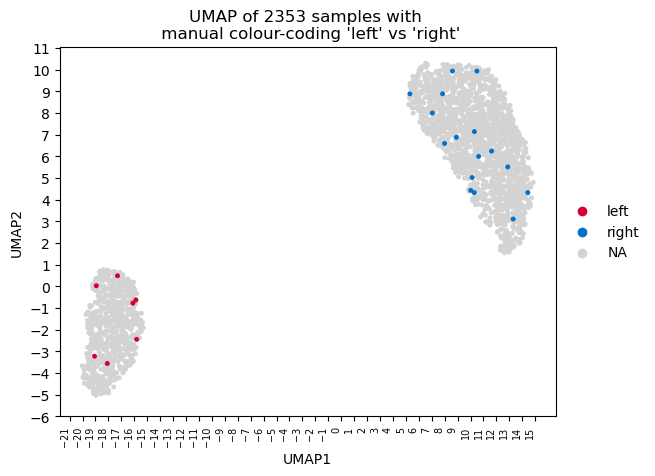

In [13]:
ax = sc.pl.umap(umap_anndata, color = 'left_vs_right',
               palette = {"left": palette.core_pink,
                         "right": palette.core_blue},
               use_raw=False,
               show = False)

ax.set_yticks(list(range(int(np.floor(min(umap_anndata.obsm['X_umap'][:, 1]))), 
                         int(np.ceil(max(umap_anndata.obsm['X_umap'][:, 1]))) + 1, 1)))
ax.set_xticks(list(range(int(np.floor(min(umap_anndata.obsm['X_umap'][:, 0]))), 
                         int(np.ceil(max(umap_anndata.obsm['X_umap'][:, 0]))) + 1, 1)))
plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right', fontsize='x-small')

ax.set_title("UMAP of 2353 samples with \n manual colour-coding 'left' vs 'right'")

# plt.savefig(workdir + 'random_unflipped_fish_umap.png', bbox_inches='tight')
# plt.savefig(workdir + 'random_unflipped_fish_umap.svg', bbox_inches='tight')

plt.show()

PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_D12


NameError: name 'workdir' is not defined

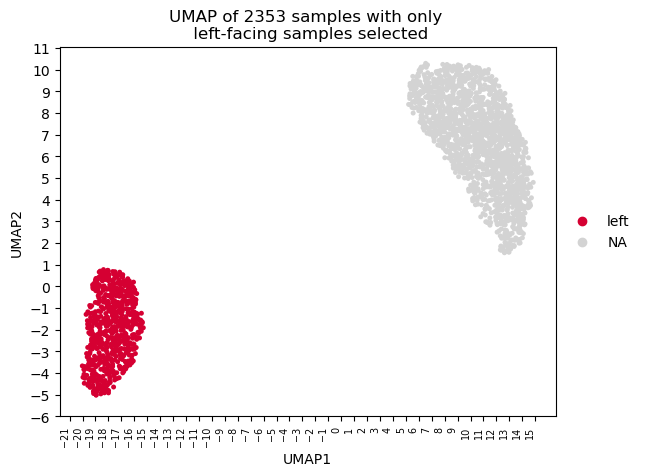

In [15]:
# Get all idx for left-facing fish
left_idx = [i for i, x in enumerate(umap_anndata.obsm['X_umap'][:, 0]) if x <= -10]
print(umap_anndata.obs_names[left_idx[0]])

left_facing = pd.DataFrame({'img_name': umap_anndata.obs_names[left_idx], 
                            'left_facing': ['left']*len(left_idx)})

direction_df2 = direction_df.merge(left_facing, 
                                  left_on = 'samplename',
                                  right_on = 'img_name',
                                  how = 'left').drop(columns = 'img_name')

umap_anndata.obs["left_facing"] = pd.Categorical(direction_df2['left_facing'])

ax = sc.pl.umap(umap_anndata, color = 'left_facing',
               palette = {"left": palette.core_pink,
                         "right": palette.core_blue},
               use_raw=False,
               show = False)

ax.set_yticks(list(range(int(np.floor(min(umap_anndata.obsm['X_umap'][:, 1]))), 
                         int(np.ceil(max(umap_anndata.obsm['X_umap'][:, 1]))) + 1, 1)))
ax.set_xticks(list(range(int(np.floor(min(umap_anndata.obsm['X_umap'][:, 0]))), 
                         int(np.ceil(max(umap_anndata.obsm['X_umap'][:, 0]))) + 1, 1)))
plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right', fontsize='x-small')

ax.set_title("UMAP of 2353 samples with only \n left-facing samples selected")

plt.savefig(workdir + 'random_unflipped_fish_umap_left.png', bbox_inches='tight')
plt.savefig(workdir + 'random_unflipped_fish_umap_left.svg', bbox_inches='tight')

plt.show()

In [20]:
# Output the names of the left-facing fish
print(type(umap_anndata.obs))

umap_anndata.obs.to_csv('/nfs/research/birney/users/esther/medaka-img/scripts/left-facing-fish.csv', 
                        index = True)

<class 'pandas.core.frame.DataFrame'>


In [ ]:
# Create a directory to save the flipped + transformed images
flipped_transformed_files_dir = '../flipped_transformed_images2' # directory to save images that are resized and normalized
if not os.path.exists(flipped_transformed_files_dir + "/image"):
    os.makedirs(flipped_transformed_files_dir + "/image")
if not os.path.exists(flipped_transformed_files_dir + "/tensor"):
    os.makedirs(flipped_transformed_files_dir + "/tensor")

# List the original (unflipped, untransformed -- only cropped) files
list_files = os.listdir(path = '../cropped_images')
print(len(list_files))

left_facing_files = umap_anndata.obs_names[left_idx].tolist()
# print(left_facing_files[1:5])

# Flip the left-facing images
for file in natsorted(list_files):
    # print(file)
    if file.endswith('.tif'):
        image = ski.io.imread('../cropped_images/' + file)
        # This file is causing an error:
        # RuntimeError: The size of tensor a (4) must match the size of tensor b (3) at non-singleton dimension 0
        # This is due to (only?) this image having a fourth (opacity, a) channel
        if (file == 'PLATE 1 F2 VC_Female 95-1 F14 x Male 129-1 F14_G12.tif'):
            image = image[:,:,0:3]

        transformed_image = transform(PILImage.fromarray(image))
        
        if (os.path.splitext(file)[0]) in left_facing_files:
            print(os.path.splitext(file)[0])
            transformed_image = transforms.functional.hflip(transformed_image)
            # plt.imshow(transformed_image.permute(1, 2, 0))
            # plt.show()
        
        # print(transformed_image.shape)
        save_image(transformed_image, flipped_transformed_files_dir + '/image/' + file)
        torch.save(transformed_image, flipped_transformed_files_dir + '/tensor/' + os.path.splitext(file)[0] + '.pt')
    else:
        print('File ' + file + ' is not a .tif file')
        continue

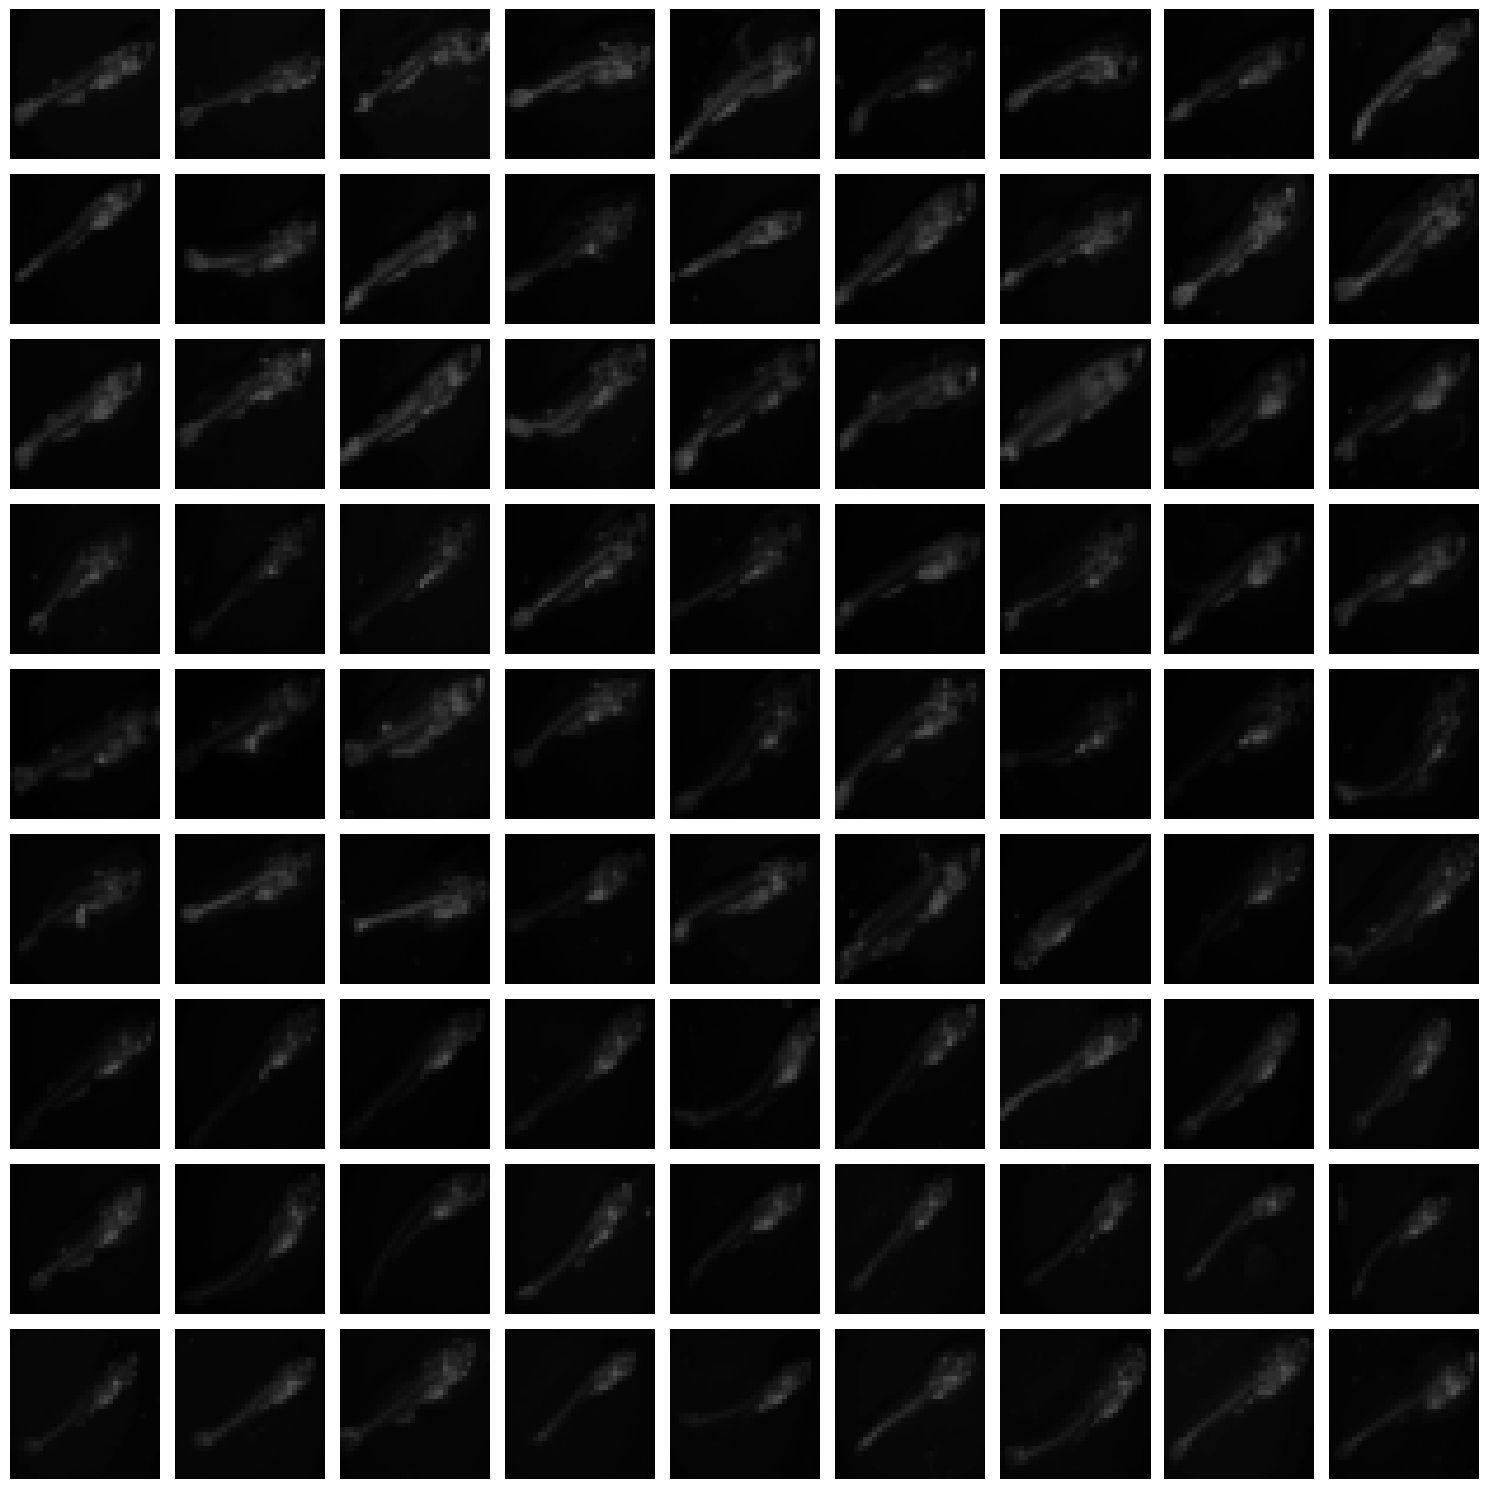

In [29]:
training_imgs = []
training_tensors = []
flipped_transformed_files_dir = '../flipped_transformed_images2' # directory to save images that are resized and normalized

training_imgs += [(flipped_transformed_files_dir + '/image/' + file) for file in os.listdir(flipped_transformed_files_dir + '/image/')]
training_tensors += [(flipped_transformed_files_dir + '/tensor/' + file) for file in os.listdir(flipped_transformed_files_dir + '/tensor/')]

training_imgs = natsorted(training_imgs)
training_tensors = natsorted(training_tensors)

# print(training_imgs)

training_tensor_names = [s.split('/tensor/')[1].split('.pt')[0] for s in training_tensors]

fig, axs = plt.subplots(9, 9, figsize=(15, 15))

# fig.suptitle("Random selection of fish images after flipping", fontsize = 15)
for i, ax in enumerate(axs.flatten()):
    if i < len(training_imgs):
        img = PILImage.open(training_imgs[i]).convert('LA')
        ax.imshow(img)
        ax.axis('off')
        # ax.set_title(os.path.basename(training_imgs[i]), fontsize = '8')
# fig.delaxes(axs.flatten())
plt.tight_layout()

# plt.savefig(workdir + 'random_unflipped_fish_imgs.png')
# plt.savefig(workdir + 'random_unflipped_fish_imgs.svg')

plt.show()

In [17]:
training_imgs[24]

'../flipped_transformed_images2/image/PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_C01.tif'

In [21]:
img = mpimg.imread('../flipped_transformed_images2/image/PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_C01.tif')
img.plt()

AttributeError: 'numpy.ndarray' object has no attribute 'plt'

In [ ]:
# Re-run model with flipped images
model_config = AEConfig(
    input_dim=(3, 32, 32),
    latent_dim=64
)

model = AE(
    model_config=model_config,
    encoder=Encoder_ResNet_AE_CIFAR(model_config), 
    decoder=Decoder_ResNet_AE_CIFAR(model_config) 
)

feature_matrix = []
counter = 0

for img_name in natsorted(os.listdir(path = flipped_transformed_files_dir + '/tensor/')):
    counter += 1
    img = torch.load(flipped_transformed_files_dir + '/tensor/' + img_name)
    feature = model.encoder(img.unsqueeze(0))

    feature_matrix.append(feature[0].detach())
    if counter % 100 == 0:
        print(counter)

In [53]:
# torch.save(feature_matrix, ('../features/pythae_ResNet_AE_CIFAR_flipped_resized_input.pt'))

In [18]:
# Re-plot UMAP with flipped images
seed = np.random.RandomState(seed=0)
neighbors_anndata_flipped = sc.pp.neighbors(feature_matrix_anndata,
                                     use_rep='X',
                                     n_neighbors = 49,
                                     random_state = seed,
                                     copy = True)
umap_anndata_flipped = sc.tl.umap(neighbors_anndata_flipped,
                          random_state = seed,
                          copy = True)

[[  8.687819    7.1981926]
 [  6.901148    9.185025 ]
 [ 10.97963     4.502554 ]
 ...
 [ 14.351952    4.588945 ]
 [-19.868666   -4.4728055]
 [ 10.2010355   8.240079 ]]
2353


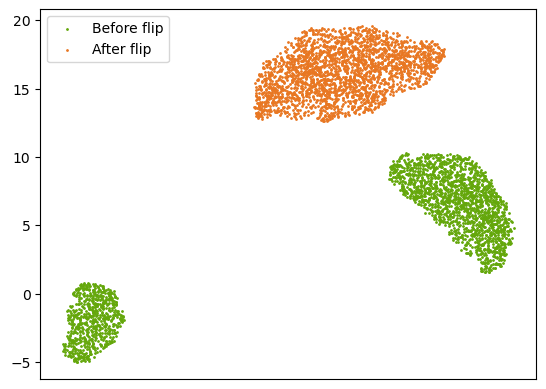

In [20]:
# ax = sc.pl.umap(umap_anndata,
#                use_raw=False,
#                show = False)
# ax2 = sc.pl.umap(umap_anndata_flipped,
#                use_raw=False,
#                show = False)

print(umap_anndata.obsm['X_umap'])
print(len(umap_anndata.obsm['X_umap'][:,0]))

plt.scatter(umap_anndata.obsm['X_umap'][:,0],
        umap_anndata.obsm['X_umap'][:,1],
        label = 'Before flip', s=1, c=palette.core_green)
plt.scatter(umap_anndata_flipped.obsm['X_umap'][:,0],
        umap_anndata_flipped.obsm['X_umap'][:,1],
        label = 'After flip', s=1, c=palette.core_orange)

plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.legend()
plt.savefig(workdir + 'umap_before_after_flip.png')
plt.savefig(workdir + 'umap_before_after_flip.svg')
plt.show()

# print(ax)
# color = 'tab:red'
# ax.set_xlabel('UMAP 1')
# ax.set_ylabel('UMAP 2', color=color)
# ax.plot(x, y, color=color)
# ax.tick_params(axis='y', labelcolor=color)

# plt.show()
# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# color = 'tab:blue'
# ax2.set_ylabel('cos', color=color)  # we already handled the x-label with ax1
# ax2.plot(x, y2, color=color)
# ax2.tick_params(axis='y', labelcolor=color)

In [17]:
# Load the feature matrix
feature_list = torch.load('../features/pythae_ResNet_AE_CIFAR_flipped_resized_input.pt')
feature_matrix = np.array(([np.array(i) for [i] in feature_list]))

# Create the AnnData object to calculate UMAP (ScanPy)
obs_names = [file.rsplit(".", 1)[0] for file in natsorted(os.listdir(path = '../flipped_transformed_images2/image/'))]

feature_matrix_anndata = sc.AnnData(X = feature_matrix)
feature_matrix_anndata.obs_names = obs_names

In [33]:
feature_matrix_anndata.write_csvs(dirname='../features/pythae_ResNet_AE_CIFAR_flipped_resized_input.csv', 
                                  skip_data = False,
                                  sep=',')

In [37]:
print(umap_anndata)
umap_anndata_flipped.obs["left_vs_right"] = pd.Categorical(direction_df['left_vs_right'])

AnnData object with n_obs × n_vars = 2353 × 64
    obs: 'left_vs_right'
    uns: 'neighbors', 'umap'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'


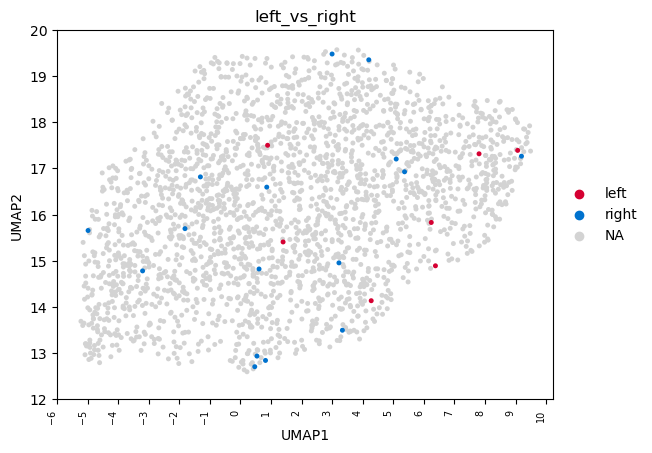

In [39]:
# ax = sc.pl.umap(umap_anndata,
#                use_raw=False,
#                show = False)

# ax.set_yticks(list(range(int(np.floor(min(umap_anndata.obsm['X_umap'][:, 1]))), 
#                          int(np.ceil(max(umap_anndata.obsm['X_umap'][:, 1]))) + 1, 1)))
# ax.set_xticks(list(range(int(np.floor(min(umap_anndata.obsm['X_umap'][:, 0]))), 
#                          int(np.ceil(max(umap_anndata.obsm['X_umap'][:, 0]))) + 1, 1)))
# plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right', fontsize='x-small')

# plt.show()

ax2 = sc.pl.umap(umap_anndata_flipped,
                 color = 'left_vs_right',
                   palette = {"left": palette.core_pink,
                             "right": palette.core_blue},
                   use_raw=False,
                   show = False)

ax2.set_yticks(list(range(int(np.floor(min(umap_anndata_flipped.obsm['X_umap'][:, 1]))), 
                         int(np.ceil(max(umap_anndata_flipped.obsm['X_umap'][:, 1]))) + 1, 1)))
ax2.set_xticks(list(range(int(np.floor(min(umap_anndata_flipped.obsm['X_umap'][:, 0]))), 
                         int(np.ceil(max(umap_anndata_flipped.obsm['X_umap'][:, 0]))) + 1, 1)))
plt.setp(ax2.get_xticklabels(), rotation=90, horizontalalignment='right', fontsize='x-small')

plt.savefig(workdir + 'umap_after_flip.png', bbox_inches='tight')
plt.savefig(workdir + 'umap_after_flip.svg', bbox_inches='tight')
plt.show()
# fig, axes = plt.subplots()
# ax.plot(x, y1, label='Plot 1')
# ax.plot(x, y2, label='Plot 2')

In [22]:
# # Downsampling 256x256 images with convolution layers
# conv_layers = [nn.Conv2d(in_channels = 3, 
#                          out_channels = 3, 
#                          kernel_size = (2, 2),
#                          stride = 4,
#                          padding = 1),
#                nn.Conv2d(in_channels = 3,
#                           out_channels = 3,
#                           kernel_size = (2, 2),
#                           stride = 2,
#                           padding = 1)]

# conv_layers.extend(model.encoder)

# conv_layers

TypeError: 'Encoder_ResNet_AE_CIFAR' object is not iterable